In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext memory_profiler

In [3]:
import sys
sys.path.append('/n/groups/datta/rockwell/') #doing this because it's where mousertclassifier is
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tqdm
import joblib

from glob import glob
from shutil import copyfile
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist, squareform
from mouse_rt_classifier.keras.util import DataGenAE
from mouse_rt_classifier.io.util import jitter_frames
from moseq2_pca.util import select_strel, clean_frames
from keras.utils import Sequence

from keras.layers import (Input, Dense, Conv2D, MaxPooling2D, 
                          UpSampling2D, Activation, BatchNormalization,
                          Flatten, Reshape, Lambda, Add, AveragePooling2D, LeakyReLU,
                          Concatenate)
from keras.initializers import Zeros
from keras.models import Model
# from keras.losses import mse
from keras import optimizers
from keras.objectives import mse
from keras import backend as K

from sklearn.model_selection import train_test_split, TimeSeriesSplit

Using TensorFlow backend.


In [4]:
# old-fashioned CAE
def unet(input_shape=(80, 80, 1),
         nfilters=[32, 16, 16],
         kernel=(3, 3),
         stride_length=(1, 1),
         kernel_initializer='glorot_uniform',
         kernel_regularizer=None,
         activation=Activation('relu'),
         decode_activation=Activation('sigmoid'),
         bottleneck_activation=Activation('relu'),
         batch_momentum=.999,
         residual=False,
         max_pooling=True,
         average_pooling=False,
         padding='same',
         batch_norm=True):

    inputs = Input(shape=input_shape)
    x = inputs

    conv_parameters = {
        'padding': padding,
        'strides': stride_length,
        'kernel_initializer': kernel_initializer,
        'kernel_regularizer': kernel_regularizer
    }

    # encode net
    encode_layers = []
    for i, filters in enumerate(nfilters):
        x = Conv2D(filters, kernel, **conv_parameters)(x)
        if batch_norm:
            x = BatchNormalization(momentum=batch_momentum)(x)
        x = activation(x)
        x = Conv2D(filters, kernel, **conv_parameters)(x)
        if batch_norm:
            x = BatchNormalization(momentum=batch_momentum)(x)
        x = activation(x)
        if max_pooling:
            x = MaxPooling2D((2, 2), padding=padding)(x)
        elif average_pooling:
            x = AveragePooling2D((2, 2), padding=padding)(x)
 
        encode_layers.append(x)

    for i, filters in enumerate(reversed(nfilters)):
        x = Conv2D(filters, kernel, **conv_parameters)(x)
        if batch_norm:
            x = BatchNormalization(momentum=batch_momentum)(x)
            x = activation(x)
        use_idx = len(encode_layers) - (i + 1)
        x = Concatenate(axis=-1)([x, encode_layers[use_idx]])
        x = Conv2D(filters, kernel, **conv_parameters)(x)
        if batch_norm:
            x = BatchNormalization(momentum=batch_momentum)(x)
            x = activation(x)
        x = Conv2D(filters, kernel, **conv_parameters)(x)
        if batch_norm:
            x = BatchNormalization(momentum=batch_momentum)(x)
            x = activation(x)
        if max_pooling or average_pooling:
            x = UpSampling2D((2, 2))(x)
        elif stride_length[0] > 1:
            x = UpSampling2D(stride_length)(x)

    decoded = Conv2D(1, kernel, padding=padding)(x)
    decoded = decode_activation(decoded)

    cae = Model(inputs, decoded)
    return cae

W0331 10:27:01.547216 140264626353984 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [5]:
#training data

# the frame file is just the training data (h5 files containing frames of video that the model will learn to warp and resize)
# the ideal training set is a behaviorally diverse but similarly sized set of mice (size should be target size for all warping)

frame_file = '/n/groups/datta/Dana/longtogeny39/training_set_1.h5'

#the cable file is either the same as the frame if there are no obstructions OR a modified version of the original frames (Simulating obstructions)
cable_file = '/n/groups/datta/Dana/longtogeny39/training_set_1.h5'

model_save_path= '/n/groups/datta/Dana/longtogeny39/longtogeny_model_training_set_1.h5'

#data to use for testing unet performance
heldout_data='/n/groups/datta/Dana/longtogeny39/3_weeks_lo/session_20190916131152/proc/results_00.h5'

#path to save figure showing how unet model performs on heldout data
figure_path='longtogeny_model_training_set_1_performance_on_session_20190916131152.pdf'

In [6]:
with h5py.File(frame_file, 'r+') as f:
    nframes = len(f['/frames'])

In [7]:
train_idx, test_set = train_test_split(np.arange(nframes), test_size=.2)
test_idx, validate_idx = train_test_split(test_set, test_size=.5)

In [8]:
nframes /= 1
nframes = int(nframes)

In [9]:
# ts_split = TimeSeriesSplit(n_splits=3)
# *_, (train_idx, test_idx) = ts_split.split(np.arange(nframes))
# ts_split = TimeSeriesSplit(n_splits=2)
# *_, (test_idx1, test_idx2) = ts_split.split(np.arange(len(test_idx)))
# validate_idx = test_idx[test_idx2]
# test_idx = test_idx[test_idx1]

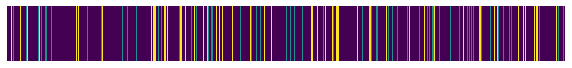

In [10]:
fig, ax = plt.subplots(1, figsize=(10,1))
tmp = np.zeros((nframes, 10))
tmp[train_idx] = 1
tmp[test_idx] = 2
tmp[validate_idx] = 3
ax.imshow(tmp[::100].T, aspect='auto')
ax.axis('off')
plt.show()

In [11]:
generator_params = {
    'batch_size': 256,
    'step_size': 1,
    'per_image_normalize': False,
    'per_feature_normalize': False,
    'scaling': None,
    'expand_dims': True,
    'jitter_frames': True,
    'jitter_position': (.8, 5),
    'jitter_rotation': (.8, 10),
    'jitter_scale': (.5, .35),
    'jitter_skew': (.5, .05),
    'jitter_flip': .25,
    'jitter_pixel': 7,
    'jitter_cable': 0.25,
    'cable_filename': cable_file,
    'filename': frame_file,
}

In [12]:
training_generator = DataGenAE('frames', subset=train_idx.astype('int'), 
                             augment_fraction=1, **generator_params)
testing_generator = DataGenAE('frames', subset=test_idx.astype('int'), 
                             augment_fraction=1, **generator_params)
validation_generator = DataGenAE('frames', subset=validate_idx.astype('int'), 
                                 augment_fraction=1, **generator_params)

In [13]:
#     multi_model = multi_gpu_model(model, gpus=2)
mdl = unet(nfilters=[16, 32, 64, 128],
           activation=Activation('relu'),
           decode_activation=Activation('linear'),
           stride_length=(1, 1),
           kernel=(3, 3),
           max_pooling=True,
           average_pooling=False,
           residual=False,
           batch_norm=True)

W0331 10:32:03.793093 140264626353984 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0331 10:32:03.798297 140264626353984 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0331 10:32:03.831408 140264626353984 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0331 10:32:03.833558 140264626353984 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto is d

In [14]:
#mdl.summary()

In [15]:
opt = optimizers.SGD(lr=1e-3, nesterov=True, momentum=.9, decay=1e-6)
mdl.compile(optimizer=opt, loss="mse")

W0331 10:32:18.170047 140264626353984 deprecation_wrapper.py:119] From /home/ra206/miniconda3/envs/unetgpu/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [16]:
mdl.fit_generator(training_generator,
                  validation_data=validation_generator,
                  use_multiprocessing=True,
                  epochs=15, 
                  workers=14,
                  max_queue_size=50,
                  shuffle=True,
                  verbose=1)

Epoch 1/15
224/224 [==============================] - 93s 414ms/step - loss: 11.8369 - val_loss: 10.7898
Epoch 2/15
224/224 [==============================] - 83s 369ms/step - loss: 7.6832 - val_loss: 9.6637
Epoch 3/15
224/224 [==============================] - 83s 371ms/step - loss: 6.9491 - val_loss: 9.0900
Epoch 4/15
224/224 [==============================] - 81s 363ms/step - loss: 6.4990 - val_loss: 10.4527
Epoch 5/15
224/224 [==============================] - 82s 367ms/step - loss: 6.1751 - val_loss: 9.3564
Epoch 6/15
224/224 [==============================] - 82s 368ms/step - loss: 5.9459 - val_loss: 9.1749
Epoch 7/15
224/224 [==============================] - 83s 371ms/step - loss: 5.7670 - val_loss: 8.2855
Epoch 8/15
224/224 [==============================] - 82s 365ms/step - loss: 5.5887 - val_loss: 10.0466
Epoch 9/15
224/224 [==============================] - 82s 367ms/step - loss: 5.4805 - val_loss: 8.4719
Epoch 10/15
224/224 [==============================] - 83s 372ms/step

In [17]:
output = mdl.predict_generator(testing_generator,
                                verbose=1).squeeze()

28/28 [==============================] - 27s 951ms/step


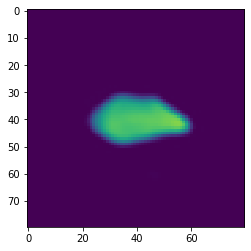

In [21]:
plt.imshow(output[1300], vmin=0, vmax=50)

In [22]:
mdl.save(model_save_path)

35988/35988 [==============================] - 6s 165us/step


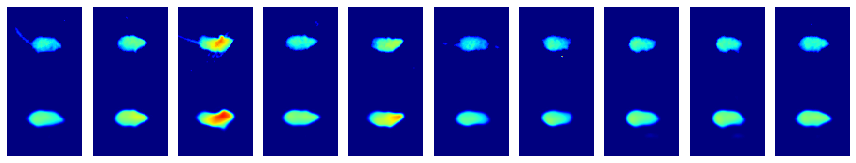

In [23]:
#testing unet on heldout data
cable_files = glob(heldout_data)

with h5py.File(cable_files[0], 'r') as f:
    test_frames = f['/frames'][...]
    
#changed cvae.predict to mdl.predict
#reconstructed original data
recon_frames = mdl.predict(test_frames[..., None].astype('float32'), 
                            verbose=1).squeeze()

choose_idx = np.random.permutation(len(recon_frames))
fig, ax = plt.subplots(1, 10, figsize=(12, 10), sharex=True, sharey=True)

for i in range(10):
    idx = choose_idx[i]
    ax[i].imshow(np.concatenate((test_frames[idx].squeeze(),
                                 recon_frames[idx].squeeze())),
                                 vmin=0, vmax=80, cmap='jet')
for _ in ax.ravel():
    _.axis('off')
plt.tight_layout()
plt.savefig(figure_path)